## Prerequisites

### Course Server Setup

#### Git clone repository or extract submitted file in home directory

If you have the zip file of this project source code, just unzip at your home directory.  

If you don't have the source code on hand, you can clone the source from git repository by the following command

```bash
git clone https://github.com/reidlai/cp631-final
```

~/cp631-final will be this project root folder.


#### Miniconda 3 setup

Miniconda is a lightweight, open-source package and environment manager developed by Anaconda, Inc. It provides a simple and efficient way to install, manage, and distribute Python packages and their dependencies across multiple platforms, including Windows, macOS, and Linux. Unlike Anaconda, which includes a large collection of pre-installed scientific computing packages, Miniconda only ships the core Conda functionality, allowing users to customize their own package collections according to their specific requirements. With Miniconda, users can easily create isolated environments, switch between them, and share them with others via portable archives or cloud services. Additionally, Miniconda supports fast and parallel package installation through its mamba engine, which significantly improves the overall performance and usability of Conda. Overall, Miniconda offers a flexible and scalable solution for managing Python packages and environments, especially for data scientists, researchers, and developers who work with complex and diverse datasets and applications.

To install miniconda3, start shell in your server.  For this case, I use course server mcs1.wlu.ca.

```bash
mkdir -p ~/miniconda3
wget https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh -O ~/miniconda3/miniconda.sh
bash ~/miniconda3/miniconda.sh -b -u -p ~/miniconda3
rm -rf ~/miniconda3/miniconda.sh
```

Once miniconda3 installed, run the following command to populate conda environment setup script into .bash_profile

```bash
~/miniconda3/bin/conda init bash
```

#### Create conda environement

Conda is a versatile tool for managing packages, dependencies, and environments for various programming languages, including Python, R, Ruby, Lua, Scala, Java, JavaScript, C/ C++, FORTRAN, and more. It is particularly popular in the fields of data science and machine learning. The conda create --name command is designed to create a new isolated environment within conda. The --name flag is followed by the name of the environment, in this case, cp631-final.


```bash
conda create --name cp631-final
```

#### SSH Tunneling for remote Jupyter Notebook connection

To allow local machine connecting to Jupyter Notebook server running in course server, VPN connection must be up and running.  Then you can use SSH Tunnelling to forward all traffic of port 8888 in local macine to course server.

```bash
ssh -L 8888:localhost:8888 wlai11@mcs1.wlu.ca
```

#### Start Jupyter Notebook server 

Once the shell has been spawn in remote server, run the following command to start jupyter notebook server with new conda environment cp631-final

```bash
conda activate cp631-final
conda install -c conda-forge -y python=3.10 pip numba=0.55.0 numpy pandas matplotlib seaborn yfinance kaggle jupyter notebook
pip3 install install mpi4py
jupyter notebook --no-browser --port=8888
```

All traffice at port 8888 will forward to localhost port

## Environment Setup

### Kaggle Authenticiation

In this notebook, we will download a dataset from Kaggle. Before beginning the download process, it is necessary to ensure an account on Kaggle available. If you do not wish to sign in and would rather bypass the login prompt by uploading your kaggle.json file directly instead, then obtain it from your account settings page and save it either in the project root directory or content directory of Google Colab before starting this notebook. This way, you can quickly access any datasets without needing to log into Kaggle every time!

### Import required packages

In [2]:
import csv
import numpy as np
import kaggle
import os
import pandas as pd
import random
import time
import yfinance as yf

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta
from mpi4py import MPI


--------------------------------------------------------------------------
[[9400,1],0]: A high-performance Open MPI point-to-point messaging module
was unable to find any relevant network interfaces:

Module: OpenFabrics (openib)
  Host: mcs1

Another transport will be used instead, although this may result in
lower performance.
--------------------------------------------------------------------------


### Initialize environment and variables

In [3]:
comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

os.environ["PROJECT_ROOT"] = "./"
params = {}

In [4]:
if params.get('cuda_installed', False): 
  from numba import cuda, float32

## S&P 500 Constituents Dataset Download

I will first need to download S&P 500 constituents from my Kaggle repository

In [5]:
kaggle.api.authenticate()
kaggle.api.dataset_download_files('reidlai/s-and-p-500-constituents', path="s-and-p-500-constituents", unzip=True)

## Stock Price History Download

get_stock_price_history_quotes function will download individual stock price history within range between start_date and end_date.

In [6]:
def get_stock_price_history_quotes(stock_symbol, start_date, end_date) -> pd.DataFrame:
    start_date = datetime.strptime(start_date, "%Y-%m-%dT%H:%M:%S")
    end_date = datetime.strptime(end_date, "%Y-%m-%dT%H:%M:%S")
    
    quotes_df = pd.DataFrame()
    
    if "." in stock_symbol:
        return None

    try:
        data = yf.download(stock_symbol, start=start_date, end=end_date, progress=False)
    except Exception as e:
        pass
    data.reset_index(inplace=True)
    data.rename(columns={
        'Date': 'date', 
        'Open': 'open',
        'High': 'high',
        'Low': 'low',
        'Close': 'close',
        'Adj Close': 'adjclose',
        'Volume': 'volume'
    }, inplace=True)
    data.insert(0, 'symbol', [stock_symbol] * data.shape[0])
    return data

## Technical Analysis

### EMA

As per proposal, we understand EMA is based on EMA value of T-1 day.  So there is dependency of daily record. And this is the main reason we cannot use CUDA for calculation.

In [7]:
def ema(values, days=12) -> np.ndarray:
    alpha = 2 / (days + 1)
    ema_values = np.empty_like(values)  # create an array to store all EMA values
    ema_values[0] = values[0]  # start with the first value
    for i in range(1, len(values)):
        ema_values[i] = alpha * values[i] + (1 - alpha) * ema_values[i - 1]
    return ema_values


### RSI

As per proposal, we understand RSI is based on value of EMA 12 and 26. So, same as ema function, there is dependency of daily records. And this is the main reason we cannot use CUDA for calculation.

In [8]:
def rsi(values, days=14) -> float:
    gains = []
    losses = []
    for i in range(1, len(values)):
        change = values[i] - values[i - 1]
        if change > 0:
            gains.append(change)
            losses.append(0)
        else:
            gains.append(0)
            losses.append(-change)
    avg_gain = sum(gains[:days]) / days
    avg_loss = sum(losses[:days]) / days
    rs = avg_gain / avg_loss if avg_loss != 0 else 0
    rsi_value = 100 - (100 / (1 + rs))
    return rsi_value

### MACD

In this section, we'll define three functions - macd, macd_cuda, and macd_gpu.

* macd function is a serial version to use dataframe calculating MACD

* macd_cuda is CUDA kernel function which has similar logic like macd except using numpy array

* macd_gpu is a wrapper function to copy data frame values into CUDA device memory and transfer back to host.

In [9]:

def macd(df, short_period=12, long_period=26, signal_period=9) -> pd.DataFrame:

    df["MACD"] = df["EMA12"] - df["EMA26"]
    return df

if params.get("cuda_installed", False):
    @cuda.jit
    def macd_cuda(ema12, ema26, macd):
        i = cuda.grid(1)
        if i < len(ema12):
            macd[i] = ema12[i] - ema26[i]
            
    def macd_gpu(df, signal_period=9):
        ema12_device = cuda.to_device(df["EMA12"].values)
        ema26_device = cuda.to_device(df["EMA26"].values)
        macd_device = cuda.to_device(np.empty_like(df["EMA12"].values))
        macd_cuda[df["EMA12"].shape[0], 1](ema12_device, ema26_device, macd_device)
        macd = macd_device.copy_to_host()
        
        del ema12_device
        del ema26_device
        del macd_device
        
        cuda.synchronize()
        cuda.current_context().memory_manager.deallocations.clear()
        
        df["MACD"] = macd
        return df

### Read stock symbols from CSV file

In [10]:
# Read symbols from the CSV file
def read_symbols_from_csvfile(csvfile_path):
    symbols = []
    with open(csvfile_path, 'r') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)  # Skip the header
        for row in reader:
            symbols.append(row[0])  # Assuming the symbol is the first column
    return symbols

### Calculating EMA12, EMA26 and RSI for Serial and Parallel programming pattern

In [11]:
def emarsi(symbols, start_date, end_date, rank, size, params):

    results = pd.DataFrame()
    # Fetch stock price history quotes using the local symbols
    for symbol in symbols:
        # Load the stock price history data into pandas DataFrame
        stock_price_history_df = get_stock_price_history_quotes(symbol, start_date, end_date)
        if stock_price_history_df is not None and stock_price_history_df.shape[0] > 0:
            stock_price_history_df['EMA12'] = stock_price_history_df['close'].ewm(span=12, adjust=False).mean()
            stock_price_history_df['EMA26'] = stock_price_history_df['close'].ewm(span=26, adjust=False).mean()
            stock_price_history_df['RSI'] = stock_price_history_df['close'].rolling(window=14).apply(rsi, raw=True)
            results = pd.concat([results, stock_price_history_df])
    return results

## Main Program

In [15]:
print(f"Rank: {rank}, Size: {size}")
local_symbols = np.array([])
symbol_trunks = np.array([])


df = pd.DataFrame()
df["numberOfProcesses"] = [size] * 5
df["numberOfStocks"] = [10, 50, 100, 200, 400]
df["numberOfDays"] = [30, 90, 180, 365, 730]

df["numberOfRows"] = df["numberOfStocks"] * df["numberOfDays"]

# Fill zeros
# df["serialElapsedTimes"] = [0.0] * len(df)
# df["parallelElapsedTimes"] = [0.0] * len(df)
df["numberOfProcesses"] = [0] * len(df)

print(f"MainBody: Rank: {rank}, Size: {size}")

for index, row in df.iterrows():
    print(f"Processing {row['numberOfStocks']} stocks for {row['numberOfDays']} days")

    previous_day = datetime.now() - timedelta(days=1)
    end_date = previous_day.strftime('%Y-%m-%dT%H:%M:%S')
    first_day = previous_day - timedelta(days=int(row["numberOfDays"]))
    start_date = first_day.strftime('%Y-%m-%dT%H:%M:%S')

    data_dir = './data'
    
    parallel_fetching_stock_start_time = MPI.Wtime()
    
    # Scatter symbols to all processes

    symbols = read_symbols_from_csvfile(os.environ["PROJECT_ROOT"] + "s-and-p-500-constituents/sandp500-20240310.csv")
    symbols = symbols[:row["numberOfStocks"].astype(int)]
    
    symbols_per_process = len(symbols) // size
    remainder = len(symbols) % size
    if remainder != 0 and rank < remainder:
        symbols_per_process += 1

    # Scatter symbols to all processes and each process should receive length of symbols / size blocks
    symbol_trunks = [symbols[i:i + symbols_per_process] for i in range(0, len(symbols), symbols_per_process)]                             
    local_symbols = comm.scatter(symbol_trunks, root=0)
    
    remote_results = emarsi(local_symbols, start_date, end_date, rank, size, params) 
    print(f"Rank: {rank}, remote_results: {remote_results}")   
    
    results = comm.gather(remote_results, root=0)
    
    if rank == 0:
        print (f"Rank: {rank}, results: {results}")
    
        results = pd.concat(results)
    
        # if not params.get("cuda_installed", False):
        #     results = macd(results)
        # else:
        #     results = macd_gpu(results)

        parallel_fetching_stock_end_time = MPI.Wtime()
        
        numberOfStocks = row["numberOfStocks"].astype(int)
        numberOfDays = row["numberOfDays"].astype(int)
    
        if not os.path.exists(os.environ["PROJECT_ROOT"] + "outputs"):
            os.makedirs(os.environ["PROJECT_ROOT"] + "outputs")
        
        results.to_csv(f"outputs/results-{size}-{numberOfStocks}-{numberOfDays}.csv", index=False)

if rank == 0:
    df.loc[index, "numberOfProcesses"] = size
    df.loc[index, "elapsedTimes"] = parallel_fetching_stock_end_time - parallel_fetching_stock_start_time


    filename = os.environ["PROJECT_ROOT"] + f"outputs/stats-{size}.csv"
    if not os.path.exists(os.environ["PROJECT_ROOT"] + "outputs"):
        os.makedirs(os.environ["PROJECT_ROOT"] + "outputs")
    df.to_csv(filename, index=False)
    print(f"Saved stats to {filename}")
        


Rank: 0, Size: 1
MainBody: Rank: 0, Size: 1
Processing 10.0 stocks for 30.0 days
Rank: 0, local_symbols: ['A', 'AAL', 'AAPL', 'ABBV', 'ABNB', 'ABT', 'ACGL', 'ACN', 'ADBE', 'ADI']
Processing 50.0 stocks for 90.0 days
Rank: 0, local_symbols: ['A', 'AAL', 'AAPL', 'ABBV', 'ABNB', 'ABT', 'ACGL', 'ACN', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK', 'AEE', 'AEP', 'AES', 'AFL', 'AIG', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALGN', 'ALL', 'ALLE', 'AMAT', 'AMCR', 'AMD', 'AME', 'AMGN', 'AMP', 'AMT', 'AMZN', 'ANET', 'ANSS', 'AON', 'AOS', 'APA', 'APD', 'APH', 'APTV', 'ARE', 'ATO', 'AVB', 'AVGO', 'AVY', 'AWK', 'AXON', 'AXP', 'AZO']
Processing 100.0 stocks for 180.0 days
Rank: 0, local_symbols: ['A', 'AAL', 'AAPL', 'ABBV', 'ABNB', 'ABT', 'ACGL', 'ACN', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK', 'AEE', 'AEP', 'AES', 'AFL', 'AIG', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALGN', 'ALL', 'ALLE', 'AMAT', 'AMCR', 'AMD', 'AME', 'AMGN', 'AMP', 'AMT', 'AMZN', 'ANET', 'ANSS', 'AON', 'AOS', 'APA', 'APD', 'APH', 'APTV', 'ARE', 'ATO', 'AVB', 'AVGO',

## Export notebook into Python Script and Run with mpirun

```bash
mpirun -np 1 -mca opal_cuda_support 1 ~/miniconda3/envs/cp631-final/bin/python ~/cp631-final/cp631_final.py
```

## Data Visualization

In [16]:
# filename_1 = os.environ["PROJECT_ROOT"] + f"outputs/stats-1.csv"

# if os.path.exists(filename_1):
#     df_stat_1 = pd.read_csv(filename)
# else:
#     df_stat_1 = None

# filename_2 = os.environ["PROJECT_ROOT"] + f"outputs/stats-2.csv"
# if os.path.exists(filename_2):
#     df_stat_2 = pd.read_csv(filename)
# else:
#     df_stat_2 = None
    
# filename_4 = os.environ["PROJECT_ROOT"] + f"outputs/stats-4.csv"
# if os.path.exists(filename_4):
#     df_stat_4 = pd.read_csv(filename)
# else:
#     df_stat_4 = None

# filename_16 = os.environ["PROJECT_ROOT"] + f"outputs/stats-16.csv"
# if os.path.exists(filename_16):
#     df_stat_16 = pd.read_csv(filename)
# else:
#     df_stat_16 = None

# df_stat = pd.concat([df_stat_1, df_stat_2, df_stat_4, df_stat_16])

In [17]:
# if params.get("in_notebook", False):
#     display(df_stat)
# else:
#     print(df_stat)

,numberOfProcesses,numberOfStocks,numberOfDays,numberOfRows,serialElapsedTimes,parallelElapsedTimes,elapsedTimes
0,1,10,30,300,0.0,0.0,1.183170
1,1,50,90,4500,0.0,0.0,4.424005
2,1,100,180,18000,0.0,0.0,9.261912
3,1,200,365,73000,0.0,0.0,19.989763
4,1,400,730,292000,0.0,0.0,45.293802


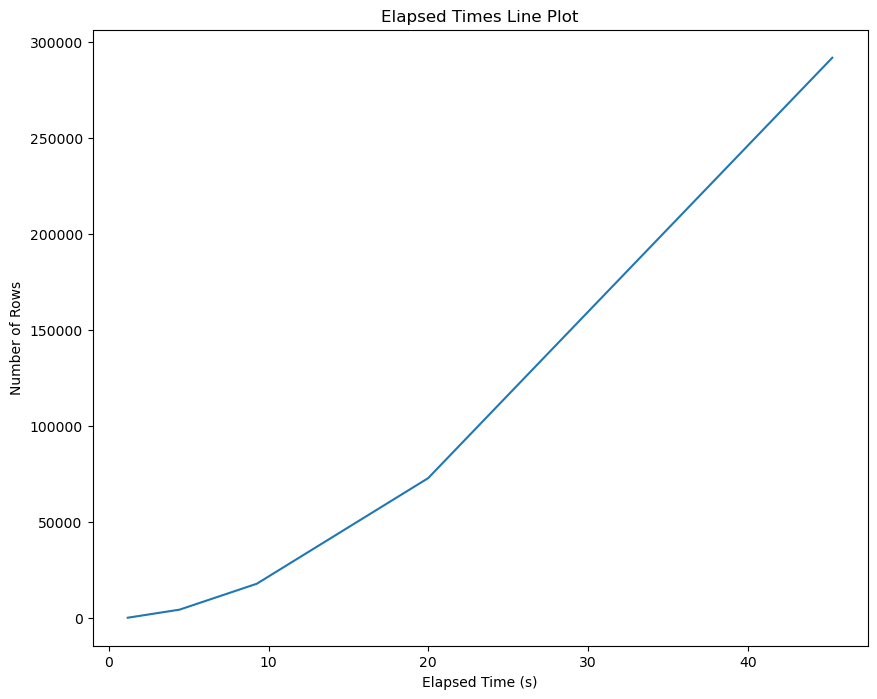

In [18]:
if params.get("in_notebook", False):
    sns.set_theme(style="whitegrid")
    # Create the line plot
    plt.figure(figsize=(10, 8))
    sns.lineplot(x='elapsedTimes', y='numberOfRows', data=df_stat)

    # Set the labels
    plt.title('Elapsed Times Line Plot')
    plt.xlabel('Elapsed Time (s)')
    plt.ylabel('Number of Rows')

    # Show the plot
    plt.show()

## Performance Analysis